<a href="https://colab.research.google.com/github/Giovannacm/digital-image-processing-msc/blob/main/CNN_Tensorflow_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidade Estadual Paulista - UNESP 

Programa de Pós-Graduação em Ciência da Computação 

Processamento de Imagens Digitais 

Professor Leandro Alves Neves

Aluna **Giovanna Carreira Marinho**

# Bibliotecas e pacotes

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

# Baixando e preparando o conjunto de dados

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQLKVOM/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQLKVOM/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Função que recebe a imagem e sua respectiva máscara. Converte os valores de intensidade da imagem de entrada para float e converte para o intervalo [0, 1]. Para a máscara, é subtraido 1 dos valores para deixar a rotulação como {0, 1, 2}, uma vez que os dados vem com os rótulos {1, 2, 3}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

Função que recebe um registro com a imagem e sua máscara de segmentação. Ambos os itens são redimensionados para o tamanho 128 x 128 pixels. Em seguida, um valor aleatório da distribuição normal/uniforme é sorteado, caso esse valor seja maior que 0.5 é feito um *flip* horizontal na imagem e na máscara. Por fim, a função anterior é aplicada para a normalização.

In [ ]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Função semelhante à anterior, entretanto, não realiza o *flip* horizontal nos dados. Essa função será utilizada para os dados de teste.

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Definição de alguns parâmetros. TRAIN_LENGTH possui a quantidade de dados de treinamento. BATCH_SIZE possui o número de dados de treinamento utilizados em uma época. BUFFER_SIZE possui o número de itens no buffer utilizado para embaralhar os dados. STEPS_PER_EPOCH calcula a quantidade de iterações a serem feitas em uma época com base no número de dados de treinamento e na quantidade de dados utilizados em uma época.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Para cada item do conjunto de dados de teste e treinamento, aplica as respectivas funções criadas anteriormente: load_image_train e load_image_test.

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

Em seguida, os dados de treinamento são embaralhados para apresentá-los à rede de uma forma aleatória. Ambos os sub-conjuntos (treinamento e teste) são ajustados de acordo de acordo com o BATCH_SIZE.

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Função para exibir uma imagem.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Analisando o quarto item do conjunto de dados: sua imagem e máscara.

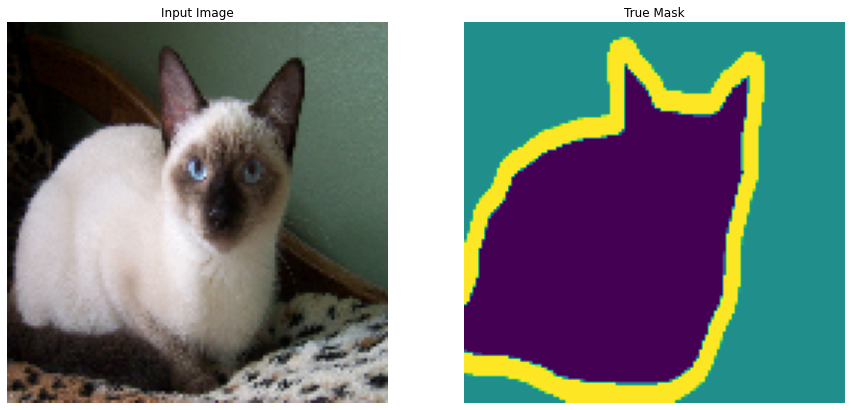

In [ ]:
for image, mask in train.take(4):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Criação do modelo

Para a criação da rede, é utilizado uma U-Net modificada (consiste em um codificador e um decodificador). 

Definindo a quantidade de canais. Como existem 3 rótulos/classes possíveis para cada pixel, seu valor é 3.

In [ ]:
OUTPUT_CHANNELS = 3

Um modelo pré-treinado MobileNetV2 (já disponibilizado pelo TensorFlow) é utilizado como codificador, suas saídas intermediárias são usadas.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


O decodificador consiste em um bloco de amostra superior já implementado no TensorFlow.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Construindo o modelo final.

In [ ]:
def unet_model(output_channels):

  # Esta é a última camada do modelo
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling através do modelo
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling e estabelecimento das conexões de salto
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Treinamento do modelo

Uma vez definido o modelo, a compilação foi realizada. Nesse processo, é definido o tipo de otimizador, a perda (uma função utilizada para determinar até que ponto os valores previstos se desviam dos valores reais durante o treinamento) e as métricas de avaliação de desempenho.

O uso dessa função de perda é devido ao fato de que a rede está tentando atribuir um rótulo à cada pixel, como se fosse a previsão de várias classes. Na máscara, cada pixel possui um valor. A rede emite três canais, onde cada um tenta aprender a prever uma classe. Esse tipo de função é recomendada para essa situação. A partir da saída da rede, o rótulo atribuído ao pixel é o canal que obteve valor mais alto (isso é feito pela função create_mask, apresentada em seguida).

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Analisando visualmente a arquitetura da rede.

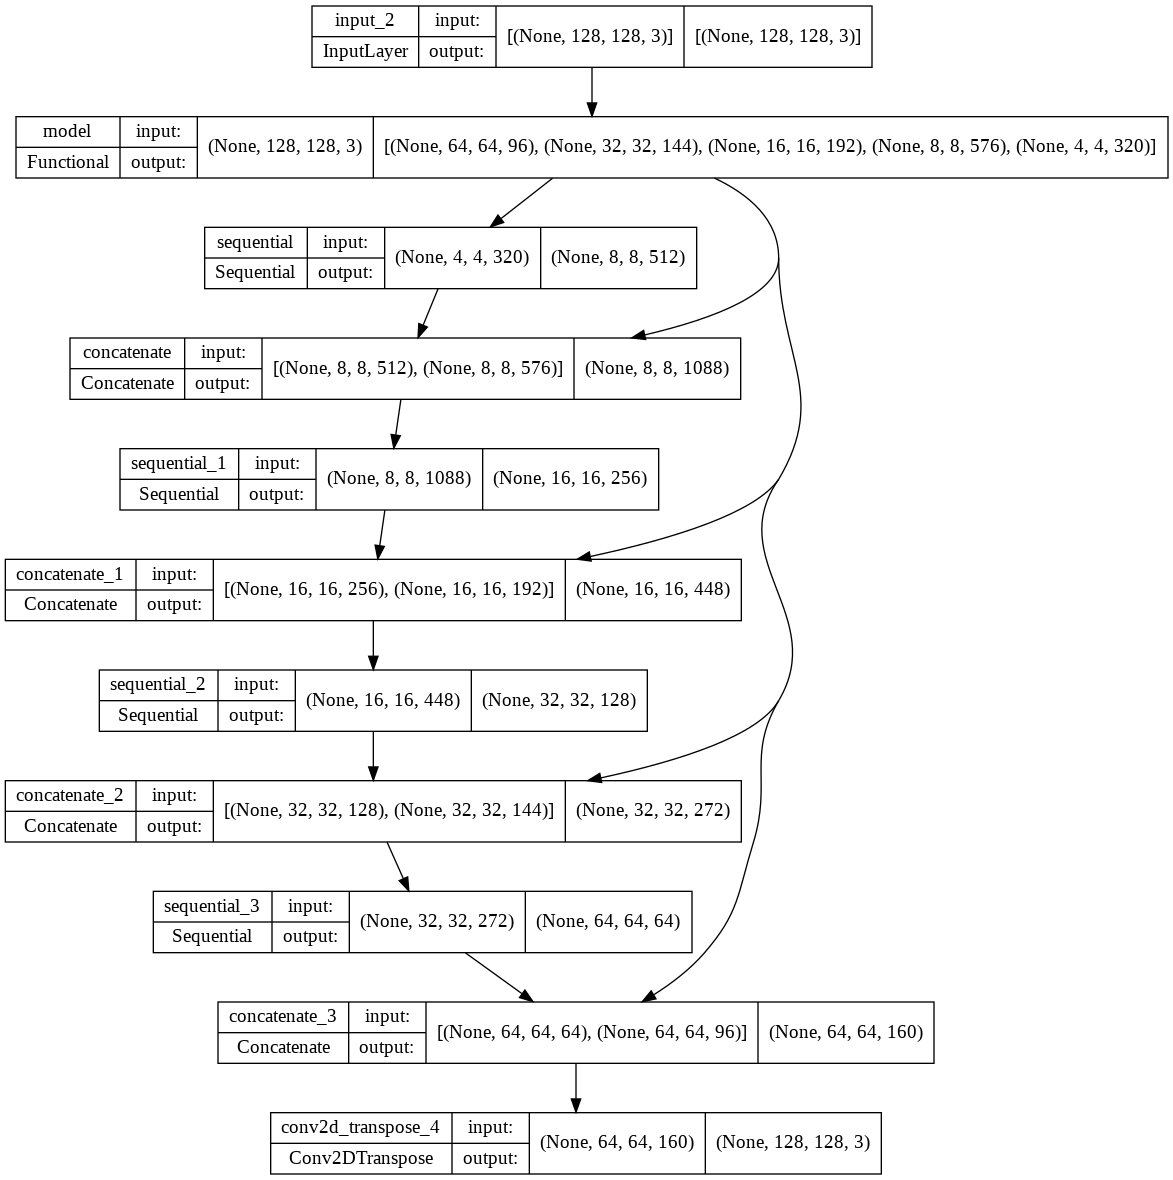

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

Função que recebe o resultado obtido pela rede, analisa o maior valor e cria a máscara prevista.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Função que exibe a imagem, seu resultado desejado da segmentação e o resultado obtido.

In [ ]:
def show_predictions(dataset=None, num=4):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Visualizando a previsão do modelo antes do treinamento.

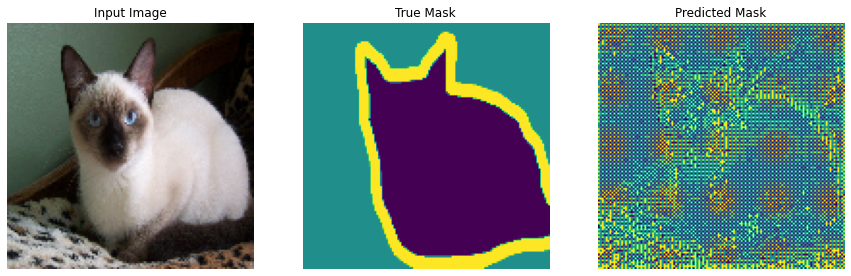

In [ ]:
show_predictions()

Sobrescrevendo um método para que, durante o treinamento, seja impresso o resultado de uma previsão.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Treinando o modelo por 20 épocas.

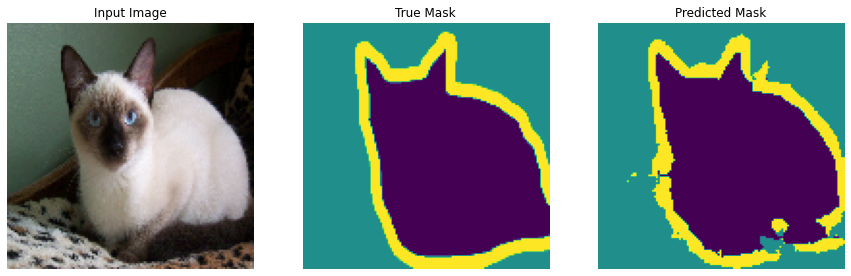


Sample Prediction after epoch 20

57/57 [==============================] - 367s 6s/step - loss: 0.1404 - accuracy: 0.9361 - val_loss: 0.3264 - val_accuracy: 0.8908


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

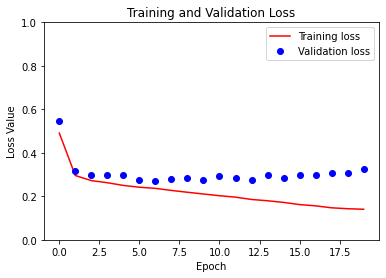

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Visualizando os filtros da rede

conv2d_transpose_4 (3, 3, 3, 160)


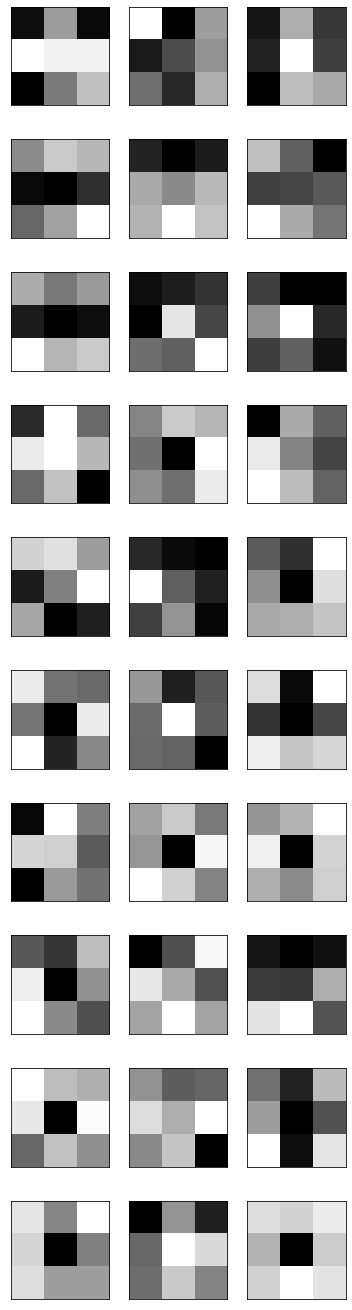

In [ ]:
plt.figure(figsize=(6, 24))
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
    
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  n_filters, ix = 10, 1
  for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
      ax = plt.subplot(n_filters, 3, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(f[:, :, j], cmap='gray')
      ix += 1
plt.show()

## Visualizando os mapas de recurso da rede com uma imagem

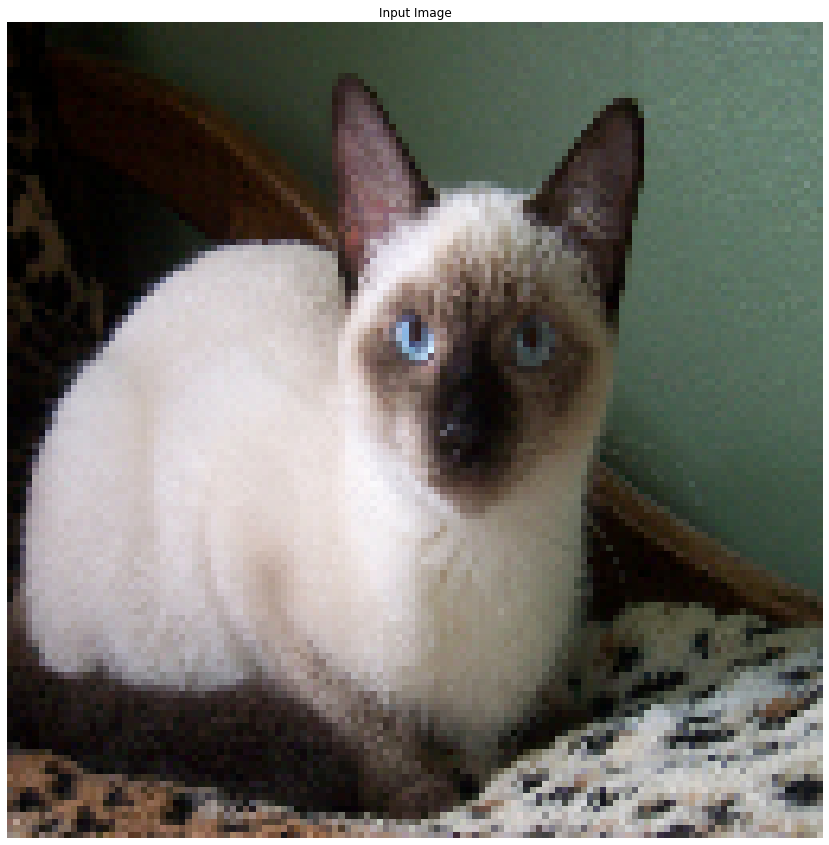

In [ ]:
for image, mask in train.take(4):
  img, _ = image, mask
display([img])

In [ ]:
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input

(1, 128, 128, 3)


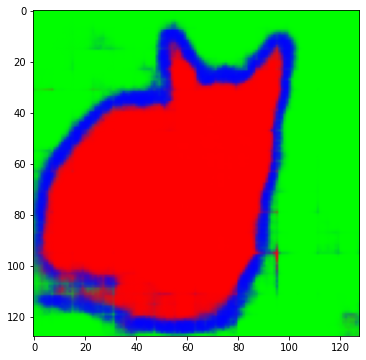

In [ ]:
plt.figure(figsize=(6, 6))
feature_maps = model.predict(img)
print(feature_maps.shape)
for fmap in feature_maps:
  plt.imshow(fmap, cmap='gray')
  plt.show()

# Previsão com o conjunto de teste

Fazendo previsões com o conjunto de teste.

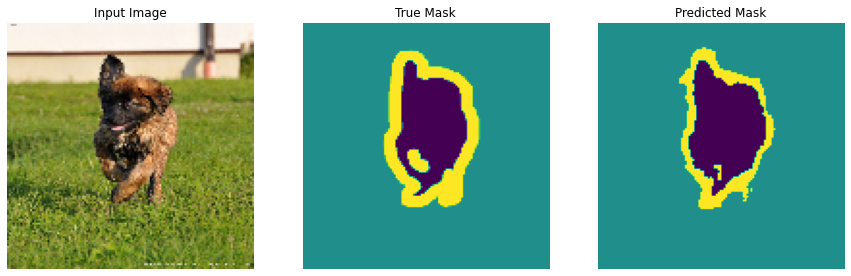

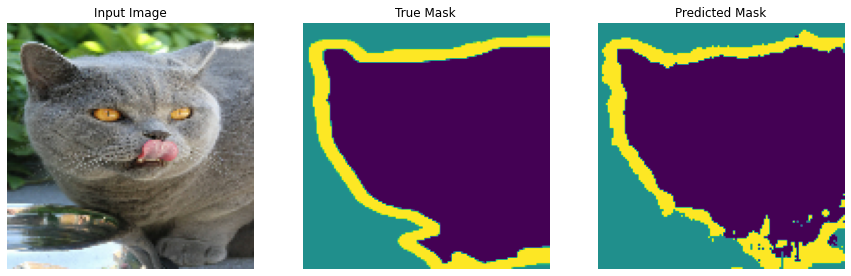

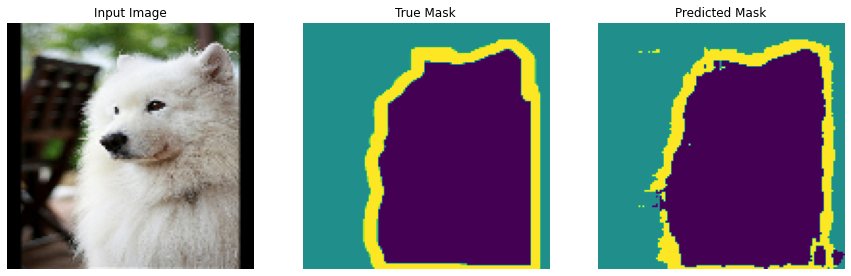

In [ ]:
show_predictions(test_dataset, 3)

Referência: 

https://www.tensorflow.org/tutorials/images/segmentation